In [21]:
import pandas as pd
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from scipy.optimize import curve_fit
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold
from sklearn.metrics import r2_score

from model import hill_activation, hill_activation_and, random_search

In [22]:
def plot_heatmap(heatmaps):
    
    f, axs = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(18, 6))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(heatmaps):
            sns.heatmap(heatmaps[i][1], annot=True, fmt='.2f', cmap='cividis', ax=ax)
            ax.set_xlabel('Ara')
            ax.set_ylabel('Cuma')
            ax.set_title(heatmaps[i][0])
        else:
            ax.set_visible(False)
    plt.tight_layout()
    plt.show()

In [23]:
def generate_map(dictionary):
    
    sample_map = pd.Series(dictionary['short_name'].values, index=dictionary['id']).to_dict()
    sample_map.update({
        'BK': 'blank-kan',
        'BA': 'blank-amp',
        '3K3-N': 'negative-control-kan',
        '4A3-N': 'negative-control-amp',
        '4A3-P': 'positive-control-amp'
    })
    return sample_map

def transpose_data(df, col):
    
    df.set_index(col, inplace=True)
    df = df.transpose().reset_index()
    df = df.set_index('index')
    return df

def generate_metadata(well, plate_map, sample_map):
    
    df = pd.merge(well, plate_map, on='Well', how='left').dropna(subset=['value']).reset_index(drop=True)
    df['short_name'] = df['value'].map(sample_map) + '_' + df['suffix'].astype(str)
    return df.dropna()

def generate_data(df, name, datapoint=2, num_data=4, start_idx=3, col='short_name'):
    
    datas = []
    idxs = [start_idx]
    for i in range(1, num_data+1):
        idxs.append(idxs[i-1] + datapoint)
        data = (df.iloc[:, idxs[i-1]:idxs[i]]).astype(float)
        data = pd.concat([name, data], axis=1)
        data = transpose_data(data, col)
        datas.append(data)
    return datas

def get_blank_corrected(data):
    
    blank_corrected = data.sub(data[filter(lambda x: x.startswith('blank'), data.columns)].mean(axis=1), axis=0)
    return blank_corrected.drop(filter(lambda x: x.startswith('blank'), blank_corrected.columns), axis=1).reset_index(drop=True)

def get_neg_ctrl_corrected(fluo, od):
    
    blank_corr_fluo = get_blank_corrected(fluo)
    blank_corr_od = get_blank_corrected(od)
    data = blank_corr_fluo / blank_corr_od
    neg_corrected = data.sub(data[filter(lambda x: x.startswith('negative-control'), data.columns)].mean(axis=1), axis=0)
    return neg_corrected.drop(filter(lambda x: x.startswith('negative-control'), neg_corrected.columns), axis=1)

In [24]:
folder = '033-all-and-gates-characterization'
cumas = np.round([2.1140508404516445e-16, 0.013913767421852795, 0.04708753302668632, 0.1481921474634383,
                  0.38432925220642106, 0.706446628596465], 3)
aras = np.round([1.0957813643749393e-17, 1.2060287427482614, 2.636411170614044, 4.633309896886311,
                 6.3697279021373925, 7.370992838892073], 3)

In [25]:
def read_map(plate_map, ctrl_replicate, induction_lvl=6):
    
    plate_map = plate_map.melt(id_vars=['group'])
    plate_map['variable'] = plate_map['variable'].astype(int)
    plate_map['Well'] = plate_map['group'] + plate_map['variable'].apply(lambda x: '{:02d}'.format(x))
    plate_map.loc[~plate_map['group'].isin(['G', 'H']), 'suffix'] = (plate_map['group'].apply(lambda x: str(ord(x)- 65))) + ((plate_map['variable'] - 1) % induction_lvl).astype(str)
    plate_map.loc[plate_map['group'].isin(['G', 'H']), 'suffix'] = (plate_map['variable'] - 1) % ctrl_replicate
    return plate_map[['Well', 'value', 'suffix']].dropna()

In [26]:
heatmaps = []
responses = []
h = 6
timepoint = 3 * h
for i in tqdm(range(6)):
    
    ctrl_replicate = 3 if i!=5 else 2
    sample_map = generate_map(pd.read_csv('datasets/dictionary.csv'))
    plate_map = read_map(pd.read_csv('datasets/experiment/{}/induction_matrix/plate{}_map.csv'.format(folder, i+1)),
                         ctrl_replicate)
    raw_data = pd.read_csv('datasets/experiment/{}/induction_matrix/plate{}.csv'.format(folder, i+1), skiprows=[0])
    metadata = generate_metadata(raw_data['Well'], plate_map, sample_map)
    datas = generate_data(raw_data[raw_data['Well'].isin(metadata['Well'])].reset_index(drop=True),
                          metadata['short_name'], datapoint=int((raw_data.shape[1] - 3)/4))
    
    samples = get_neg_ctrl_corrected(datas[1][filter(lambda x: '-amp' not in x, datas[1].columns)],
                                 datas[0][filter(lambda x: '-amp' not in x, datas[0].columns)])
    reporter = get_neg_ctrl_corrected(datas[1][filter(lambda x: '-amp' in x, datas[1].columns)],
                              datas[0][filter(lambda x: '-amp' in x, datas[0].columns)])
    
    samples_t = samples.iloc[timepoint]
    
    for col in [e for e in plate_map['value'].unique() if e.startswith('A')]:
        
        fluo = samples_t[filter(lambda x: x.startswith(sample_map[col]), samples_t.index)]
        fluo_t = fluo.reset_index().rename(columns={'short_name': 'gate'})
        fluo_t['cuma'] = fluo_t['gate'].str[-2]
        fluo_t['ara'] = fluo_t['gate'].str[-1]
        fluo_t[18] = fluo_t[18]#/np.mean(reporter.values)
        responses.append(fluo_t)
        fluo_pvt = fluo_t.drop('gate', axis=1).pivot('cuma', 'ara')
        fluo_pvt.index = cumas
        fluo_pvt.columns = aras
        heatmaps.append((sample_map[col], fluo_pvt/np.mean(reporter.values)))
        #heatmaps.append((sample_map[col], fluo_pvt))
        

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 14.86it/s]


In [27]:
len(heatmaps)

11

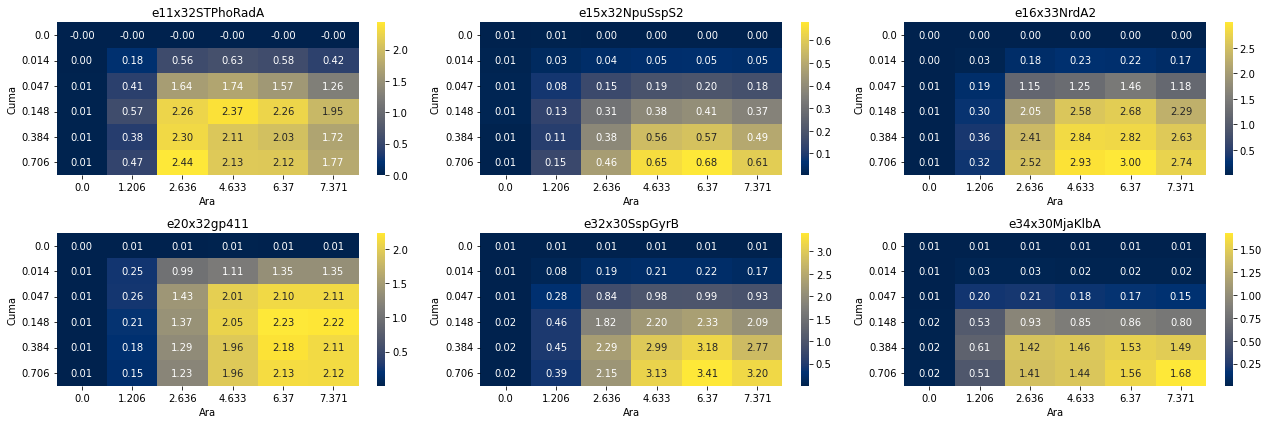

In [28]:
plot_heatmap(heatmaps[:12])

In [ ]:
plot_heatmap(heatmaps[6:12])

In [29]:
def read_map(P1, P2, induction_lvl=6, ctrl_replicate=2):
    
    plate_map_builder = [[P1] * 6 + [P2] * 6 for _ in range(6)]
    plate_map_builder.append([None] * 12)
    plate_map_builder.append([None, None, 'BK', 'BK', '3K3-N', '3K3-N', 'BA', 'BA', '4A3-N', '4A3-N', '4A3-P', '4A3-P'])
    plate_map = pd.concat([pd.Series(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']),
               pd.DataFrame(np.array(plate_map_builder))], axis=1)
    plate_map.columns = ['group', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
    plate_map = plate_map.melt(id_vars=['group'])
    plate_map['variable'] = plate_map['variable'].astype(int)
    plate_map['Well'] = plate_map['group'] + plate_map['variable'].apply(lambda x: '{:02d}'.format(x))
    plate_map.loc[~plate_map['group'].isin(['G', 'H']), 'suffix'] = (plate_map['group'].apply(lambda x: str(ord(x)- 65))) + ((plate_map['variable'] - 1) % induction_lvl).astype(str)
    plate_map.loc[plate_map['group'].isin(['G', 'H']), 'suffix'] = (plate_map['variable'] - 1) % ctrl_replicate
    return plate_map[['Well', 'value', 'suffix']].dropna()

In [30]:
gates_list = pd.read_csv('datasets/experiment/{}/plate_map.csv'.format(folder))
#heatmaps = []

for i in tqdm(range(len(gates_list))):
    
    P1, P2 = gates_list.iloc[i].tolist()
    plate_map = read_map(P1, P2)
    
    a, b = str(i*2+1).zfill(3), str(i*2+2).zfill(3)
    raw_data = pd.read_csv('datasets/experiment/{}/{}-{}.csv'.format(folder, a, b), skiprows=[0])
    sample_map = generate_map(pd.read_csv('datasets/dictionary.csv'))
    metadata = generate_metadata(raw_data['Well'], plate_map, sample_map)
    data = raw_data[raw_data['Well'].isin(metadata['Well'])].reset_index(drop=True)
    datas = generate_data(data, metadata['short_name'], datapoint=int((raw_data.shape[1] - 3)/4))
    
    samples = get_neg_ctrl_corrected(datas[1][filter(lambda x: '-amp' not in x, datas[1].columns)],
                                 datas[0][filter(lambda x: '-amp' not in x, datas[0].columns)])
    reporter = get_neg_ctrl_corrected(datas[1][filter(lambda x: '-amp' in x, datas[1].columns)],
                                  datas[0][filter(lambda x: '-amp' in x, datas[0].columns)])
    
    samples_t = samples.mean()
    
    fluo = samples_t[filter(lambda x: x.startswith(sample_map[P1]), samples_t.index)]
    fluo_t = fluo.reset_index().rename(columns={'short_name': 'gate'})
    fluo_t['cuma'] = fluo_t['gate'].str[-2]
    fluo_t['ara'] = fluo_t['gate'].str[-1]
    responses.append(fluo_t)
    fluo_pvt = fluo_t.drop('gate', axis=1).pivot('cuma', 'ara')
    fluo_pvt.index = cumas
    fluo_pvt.columns = aras
    heatmaps.append((sample_map[P1], fluo_pvt/np.mean(reporter.values)))
    
    fluo = samples_t[filter(lambda x: x.startswith(sample_map[P2]), samples_t.index)]
    fluo_t = fluo.reset_index().rename(columns={'short_name': 'gate'})
    fluo_t['cuma'] = fluo_t['gate'].str[-2]
    fluo_t['ara'] = fluo_t['gate'].str[-1]
    responses.append(fluo_t)
    fluo_pvt = fluo_t.drop('gate', axis=1).pivot('cuma', 'ara')
    fluo_pvt.index = cumas
    fluo_pvt.columns = aras
    heatmaps.append((sample_map[P2], fluo_pvt/np.mean(reporter.values))) 

100%|███████████████████████████████████████████| 55/55 [00:02<00:00, 21.35it/s]


In [31]:
len(responses)

121

In [ ]:
data = responses[1].copy()
data['cumas'] = data['cuma'].apply(lambda x: cumas[int(x)])
data['aras'] = data['ara'].apply(lambda x: aras[int(x)])
X = data[['cumas', 'aras']]
y = data[timepoint]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
regr = RandomForestRegressor(random_state=0)
regr.fit(X_train, y_train)

In [ ]:
r2_score(y_test, regr.predict(X_test))

In [ ]:
regr = RandomForestRegressor()
cross_val_score(regr, X, y, scoring='r2', cv=KFold(shuffle=True))

In [ ]:
resp_perfs = []
resp_perfs = []
for data in tqdm(responses[:9]):
    
    data['cumas'] = data['cuma'].apply(lambda x: cumas[int(x)])
    data['aras'] = data['ara'].apply(lambda x: aras[int(x)])
    X = data[['cumas', 'aras']]
    y = data[timepoint]
    
    resp_perf = []
    for i in range(10):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        regr = RandomForestRegressor()
        resp_perf.append(cross_val_score(regr, X, y, scoring='r2', cv=KFold(shuffle=True)))
        
    resp_perfs.append(resp_perf)

In [ ]:
gates = ['E11', 'E15', 'E16', 'E20', 'E32', 'E34', 'E38', 'E41']
plt.figure(figsize=[8, 3])
for i, resp in enumerate(resp_perfs[:8]):
    plt.errorbar(gates[i], np.mean(resp), np.std(resp), color='darkblue', marker='o')
plt.ylim([0, 1.2])
plt.show()

#### Plotting

In [8]:
heatmaps[0][1]

,0.000,1.206,2.636,4.633,6.370,7.371
0.000,-0.002149,-0.001857,-0.001072,-0.002528,-0.001213,-0.002367
0.014,0.003155,0.181602,0.559687,0.627593,0.581832,0.420211
0.047,0.008328,0.413263,1.640755,1.738711,1.569460,1.259894
0.148,0.008465,0.570502,2.258455,2.374840,2.262509,1.946736
0.384,0.008384,0.376664,2.300439,2.108962,2.033997,1.717583
0.706,0.008669,0.470745,2.435088,2.133630,2.121035,1.769055


In [9]:
hill_params = []
fluo = heatmaps[0][1]
fluo = fluo.reset_index().melt('index', var_name='ara', value_name='fluo')
fluo.rename(columns={'index': 'cuma'}, inplace=True)

x1, x2 = np.meshgrid(cumas, aras)
x = np.vstack((x1.ravel(), x2.ravel()))
y = np.abs(fluo['fluo'].values)

gate_bounds = [[0, 0, 0, 0, 0, 0, 0, 0],
               [1e3, 1e3, 4, 4, y.min()+0.1, y.min()+0.1, y.max()+0.5*y.max(), y.max()+0.5*y.max()]]

init_guess = random_search(30, x, y, gate_bounds, hill_activation_and)
popt, pcov = curve_fit(hill_activation_and, x, y, p0=init_guess, bounds=gate_bounds)

y_pred = hill_activation_and(x, *popt)
hill_params.append((heatmaps[i][0], *popt))

#ys.append((heatmaps[i][0], y, y_pred))

arr_ind1 = np.arange(0, np.max(cumas), 0.005)
arr_ind2 = np.arange(0, np.max(aras), 0.05)
x1_, x2_ = np.meshgrid(arr_ind1, arr_ind2)
x_ = np.vstack((x1_.ravel(), x2_.ravel()))
y_pred_ = hill_activation_and(x_, *popt)

<AxesSubplot:>

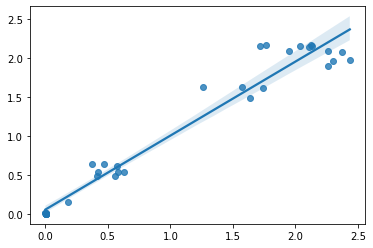

In [11]:
sns.regplot(y, y_pred)

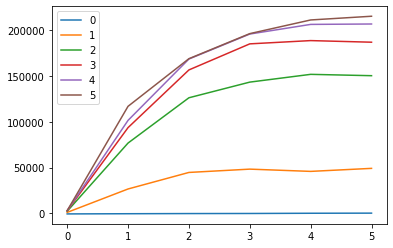

In [43]:
data = responses[17].copy()
cuma_lvl = data['cuma'].unique()
for cuma in cuma_lvl:
    selection = data[data['cuma']==cuma].reset_index(drop=True)
    plt.plot(selection.index, selection[0], label=cuma)
plt.legend()
plt.show()

In [41]:
responses[15]

,gate,0,cuma,ara
0,e20x30STsSspDnaX_00,313.125643,0,0
1,e20x30STsSspDnaX_01,1645.024524,0,1
2,e20x30STsSspDnaX_02,2796.250641,0,2
3,e20x30STsSspDnaX_03,4028.316240,0,3
4,e20x30STsSspDnaX_04,5053.403708,0,4
5,e20x30STsSspDnaX_05,5518.763406,0,5
6,e20x30STsSspDnaX_10,481.656458,1,0
7,e20x30STsSspDnaX_11,14909.945158,1,1
8,e20x30STsSspDnaX_12,29389.280589,1,2
9,e20x30STsSspDnaX_13,37439.512364,1,3


In [56]:
data = responses[4].copy()
selection = data[data['cuma']=='5'].reset_index(drop=True)
selection

,gate,18,cuma,ara
0,e32x30SspGyrB_50,509.944882,5,0
1,e32x30SspGyrB_51,11522.342072,5,1
2,e32x30SspGyrB_52,63550.905659,5,2
3,e32x30SspGyrB_53,92518.137503,5,3
4,e32x30SspGyrB_54,100753.613493,5,4
5,e32x30SspGyrB_55,94655.171368,5,5


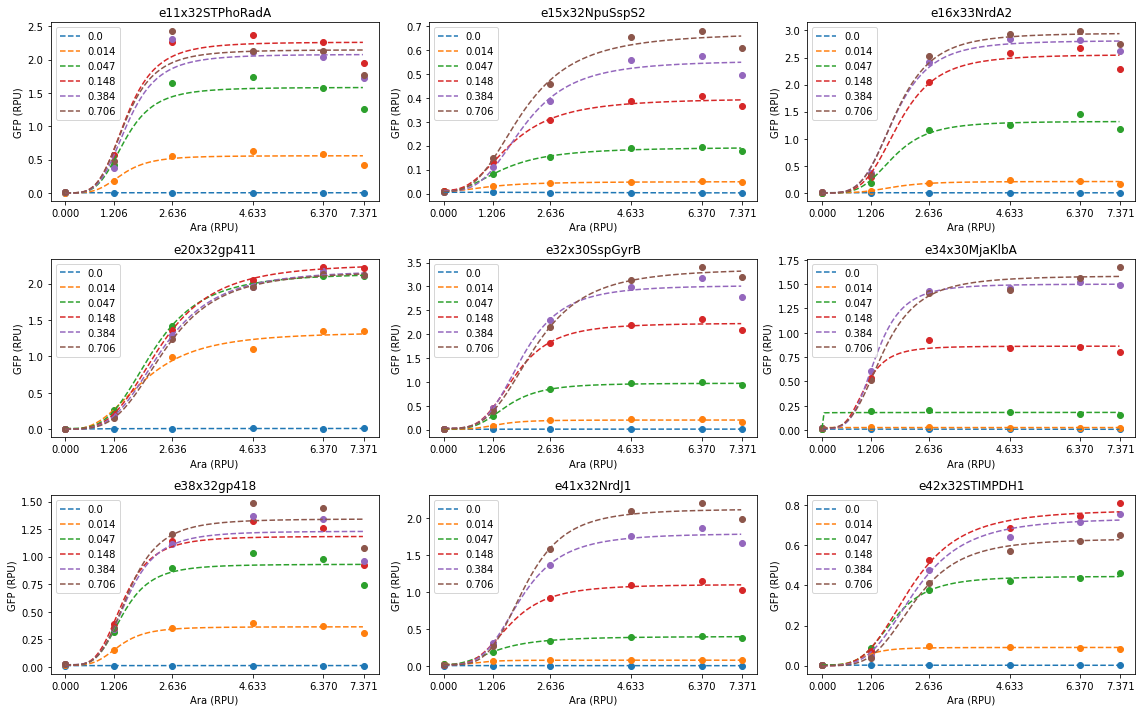

In [171]:
x = aras
f, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(16, 10))
axr = axs.ravel()
hill_params = []
for i, ax in enumerate(axr):
    if i < len(responses[:9]):
        data = responses[i].copy()
        cuma_lvl = data['cuma'].unique()
        for cuma in cuma_lvl:
            selection = data[data['cuma']==cuma].reset_index(drop=True)

            y = np.abs(selection[18])
            gate_bounds = [[0, 0, 0, 0],
                           [1e2, 4, y.min()+0.1, y.max()+0.5*y.max()]]

            init_guess = random_search(30, x, y, gate_bounds, hill_activation)
            popt, pcov = curve_fit(hill_activation, x, y, p0=init_guess, bounds=gate_bounds)

            y_pred = hill_activation(np.arange(0, np.max(x), 0.05), *popt)
            hill_params.append((cumas[int(cuma)], *popt))

            ax.plot(np.arange(0, np.max(x), 0.05), y_pred, label=cumas[int(cuma)], linestyle='dashed')
            ax.scatter(x, y)

        ax.set_xticks(x)
        ax.set_xlabel('Ara (RPU)')
        ax.set_ylabel('GFP (RPU)')
        ax.set_title(data['gate'].iloc[0][:-3])
        ax.legend()
    else:
        ax.set_visible(False)

plt.tight_layout()

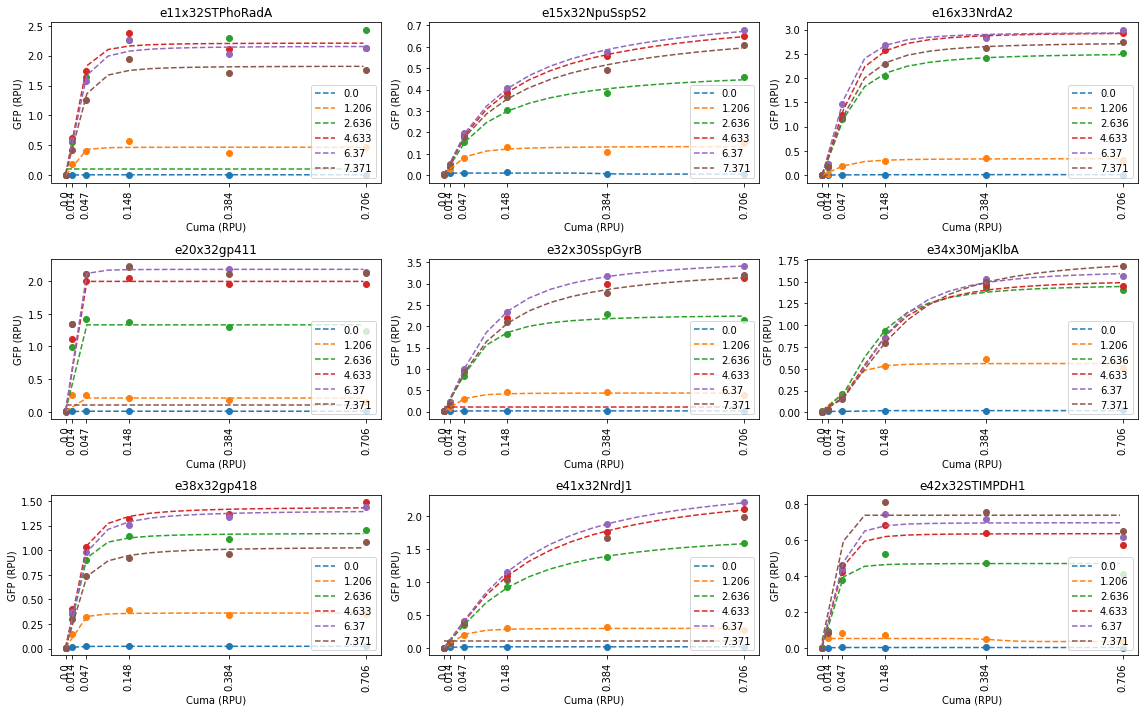

In [170]:
x = cumas
f, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(16, 10))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(responses[:9]):
        data = responses[i].copy()
        ara_lvl = data['ara'].unique()
        for ara in ara_lvl:
            selection = data[data['ara']==ara].reset_index(drop=True)

            y = np.abs(selection[18])
            gate_bounds = [[0, 0, 0, 0],
                           [1e2, 100, y.min()+0.1, y.max()+0.5*y.max()]]

            init_guess = random_search(30, x, y, gate_bounds, hill_activation)
            popt, pcov = curve_fit(hill_activation, x, y, p0=init_guess, bounds=gate_bounds)

            y_pred = hill_activation(np.arange(0, np.max(x), 0.05), *popt)
            
            #ax.loglog()
            ax.plot(np.arange(0, np.max(x), 0.05), y_pred, label=aras[int(ara)], linestyle='dashed')
            ax.scatter(x, y)

        ax.set_xticks(x)
        ax.set_xticklabels(x, rotation=90)
        ax.set_xlabel('Cuma (RPU)')
        ax.set_ylabel('GFP (RPU)')
        ax.set_title(data['gate'].iloc[0][:-3])
        ax.legend(loc=4)
    else:
        ax.set_visible(False)

plt.tight_layout()

In [ ]:
data = responses[1].copy()
ara_lvl = data['ara'].unique()
for ara in ara_lvl:
    selection = data[data['ara']==ara].reset_index(drop=True)
    plt.plot(selection.index, selection[18], label=ara)
plt.legend()
plt.show()